- [CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html?highlight=lstm)

## Preparing the Data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from random import shuffle
from sklearn.model_selection import train_test_split
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import unicodedata

### Loading the data

In [2]:
DIRECTORY = './data/names/'
ALL_LETTERS = string.ascii_letters + " .,;'"

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for fname in os.listdir(DIRECTORY): 
    path = os.path.join(DIRECTORY, fname)
    category = os.path.splitext(os.path.basename(fname))[0]
    all_categories.append(category)
    lines = readLines(path)
    category_lines[category] = lines

n_categories = len(all_categories)
for i, category in enumerate(all_categories):
    print("%2d. %12s: %4d" % (i + 1, category, len(category_lines[category])))
print(", ".join(category_lines['Italian'][:5]))

 1.       Arabic: 2000
 2.      Chinese:  268
 3.        Czech:  519
 4.        Dutch:  297
 5.      English: 3668
 6.       French:  277
 7.       German:  724
 8.        Greek:  203
 9.        Irish:  232
10.      Italian:  709
11.     Japanese:  991
12.       Korean:   94
13.       Polish:  139
14.   Portuguese:   74
15.      Russian: 9408
16.     Scottish:  100
17.      Spanish:  298
18.   Vietnamese:   73
Abandonato, Abatangelo, Abatantuono, Abate, Abategiovanni


In [4]:
X_train = []
y_train = []

X_test = []
y_test = []

for i, category in enumerate(all_categories):
    names_train, names_test = train_test_split(
        category_lines[category], 
        test_size=0.10, 
        random_state=42
    )
    X_train.extend(names_train)
    y_train.extend([category] * len(names_train))

    X_test.extend(names_test)
    y_test.extend([category] * len(names_test))

    print("%12s: # train: %4d, # test: %d" % (category, len(names_train), len(names_test)))


print("All: # train: %4d / %4d, # test: %4d / %4d" % (len(X_train), len(y_train), len(X_test), len(y_test)))

n = 8
print(X_train[:n], "\n", y_train[:n])
Z = list(zip(X_train, y_train))
shuffle(Z)
X_train, y_train = zip(*Z)
print(X_train[:n], "\n", y_train[:n])
print('-----')
print(X_test[:n], "\n", y_test[:n])
Z = list(zip(X_test, y_test))
shuffle(Z)
X_test, y_test = zip(*Z)
print(X_test[:n], "\n", y_test[:n])

      Arabic: # train: 1800, # test: 200
     Chinese: # train:  241, # test: 27
       Czech: # train:  467, # test: 52
       Dutch: # train:  267, # test: 30
     English: # train: 3301, # test: 367
      French: # train:  249, # test: 28
      German: # train:  651, # test: 73
       Greek: # train:  182, # test: 21
       Irish: # train:  208, # test: 24
     Italian: # train:  638, # test: 71
    Japanese: # train:  891, # test: 100
      Korean: # train:   84, # test: 10
      Polish: # train:  125, # test: 14
  Portuguese: # train:   66, # test: 8
     Russian: # train: 8467, # test: 941
    Scottish: # train:   90, # test: 10
     Spanish: # train:  268, # test: 30
  Vietnamese: # train:   65, # test: 8
All: # train: 18060 / 18060, # test: 2014 / 2014
['Mustafa', 'Kalb', 'Kalb', 'Attia', 'Saliba', 'Basara', 'Atiyeh', 'Atiyeh'] 
 ['Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic']
('Marriott', 'Avzalov', "O'Doherty", 'Rutkowski', 'Tchaly', 'Wojda', 

### Encoding the names

In [5]:
# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = ALL_LETTERS
num_chars = len(chars)
#char2int = {ch:ii for ii, ch in enumerate(chars, 1)}

char2int = {ch:ii for ii, ch in enumerate(chars)}
int2char = {ii:ch for ch, ii in char2int.items()}

def encode_names(some_names):
    some_names_encoded = []
    for name in some_names: some_names_encoded.append([char2int[c] for c in name])
    return some_names_encoded
    
def decode_name(name): 
    return "".join(int2char[i] for i in name)    

def decode_names(some_names): 
    return [decode_name(name) for name in some_names]

X_train_encoded = encode_names(X_train)
print("# train names encoded:", len(X_train_encoded))

n = 10
X_train_decoded = decode_names(X_train_encoded[:n])
for i in range(n):
    print("%19s -->> %s" % (X_train_decoded[i], y_train[i]))
    
X_test_encoded = encode_names(X_test)
print("# test names encoded:", len(X_test_encoded))

n = 10
X_test_decoded = decode_names(X_test_encoded[:n])
for i in range(n):
    print("%19s -->> %s" % (X_test_decoded[i], y_test[i]))

# train names encoded: 18060
           Marriott -->> English
            Avzalov -->> Russian
          O'Doherty -->> Irish
          Rutkowski -->> Polish
             Tchaly -->> Russian
              Wojda -->> Polish
               Geht -->> Russian
            Pashkov -->> Russian
           Kaminaga -->> Japanese
               Bale -->> English
# test names encoded: 2014
           Makhotin -->> Russian
              Lovey -->> English
          Dubrowsky -->> Russian
              Auton -->> English
             Clough -->> English
              Getie -->> Russian
           Tovstykh -->> Russian
        Goloschapov -->> Russian
               Wong -->> English
             Jahaev -->> Russian


### Embedding names

In [6]:
seq_length = np.max([len(name) for name in X_train + X_test])
print("seq-length: %d" % seq_length, "num_chars:", num_chars)

def embed_names(some_names):
    some_names_encoded = encode_names(some_names)
    some_names_embedded = np.zeros((len(some_names), seq_length, num_chars), dtype=np.float32)
    index = 0
    for name in some_names_encoded:
        position = seq_length - len(name)
        for char in name: 
            some_names_embedded[index, position, char] = 1
            position += 1
        index += 1
    return torch.from_numpy(some_names_embedded) 

def embed2name(values, indices):
    return decode_name([int(indices[i]) for i in range(seq_length) if values[i] == 1])
    
def embed2names(names):
    batch_size = names.shape[0]
    values, indices = torch.topk(names, 1)
    values = values.squeeze()
    indices = indices.squeeze()
    return [
        embed2name(values[i], indices[i]) for i in range(batch_size)
    ]


X_train_embedded = embed_names(X_train)
print("X_train_embedded:", X_train_embedded.shape, ";", X_train_embedded.dtype)

n = 10
some_names = embed2names(X_train_embedded[:n])
for i in range(n):
    print("%19s -->> %s" % (some_names[i], y_train[i]))
    
X_test_embedded = embed_names(X_test)
print("X_test_embedded:", X_test_embedded.shape, ";", X_test_embedded.dtype)

n = 10
some_names = embed2names(X_test_embedded[:n])
for i in range(n):
    print("%19s -->> %s" % (some_names[i], y_test[i]))

seq-length: 19 num_chars: 57
X_train_embedded: torch.Size([18060, 19, 57]) ; torch.float32
           Marriott -->> English
            Avzalov -->> Russian
          O'Doherty -->> Irish
          Rutkowski -->> Polish
             Tchaly -->> Russian
              Wojda -->> Polish
               Geht -->> Russian
            Pashkov -->> Russian
           Kaminaga -->> Japanese
               Bale -->> English
X_test_embedded: torch.Size([2014, 19, 57]) ; torch.float32
           Makhotin -->> Russian
              Lovey -->> English
          Dubrowsky -->> Russian
              Auton -->> English
             Clough -->> English
              Getie -->> Russian
           Tovstykh -->> Russian
        Goloschapov -->> Russian
               Wong -->> English
             Jahaev -->> Russian


### Encoding labels

In [7]:
distinct_labels = list(set(y_train + y_test))
distinct_labels.sort()
num_classes = len(distinct_labels)
label2int = {l:i for i, l in enumerate(distinct_labels)}
int2label = {i:l for i, l in enumerate(distinct_labels)}

def encode_labels(some_labels): 
    encoded_labels = np.array([label2int[label] for label in some_labels], dtype=np.float32)
    return torch.from_numpy(encoded_labels)

def codes2labels(some_labels): 
    return [int2label[int(i)] for i in some_labels]

y_train_encoded = encode_labels(y_train)
print("encoded train labels:", y_train_encoded.shape, ";", y_train_encoded.dtype)
n = 10
some_names = embed2names(X_train_embedded[:n])
same_labels = codes2labels(y_train_encoded[:n])
for i in range(n):
    print("%19s -->> %s" % (some_names[i], same_labels[i]))


y_test_encoded = encode_labels(y_test)
print("encoded test labels:", y_test_encoded.shape, ";", y_test_encoded.dtype)
n = 10
some_names = embed2names(X_test_embedded[:n])
same_labels = codes2labels(y_test_encoded[:n])
for i in range(n):
    print("%19s -->> %s" % (some_names[i], same_labels[i]))

encoded train labels: torch.Size([18060]) ; torch.float32
           Marriott -->> English
            Avzalov -->> Russian
          O'Doherty -->> Irish
          Rutkowski -->> Polish
             Tchaly -->> Russian
              Wojda -->> Polish
               Geht -->> Russian
            Pashkov -->> Russian
           Kaminaga -->> Japanese
               Bale -->> English
encoded test labels: torch.Size([2014]) ; torch.float32
           Makhotin -->> Russian
              Lovey -->> English
          Dubrowsky -->> Russian
              Auton -->> English
             Clough -->> English
              Getie -->> Russian
           Tovstykh -->> Russian
        Goloschapov -->> Russian
               Wong -->> English
             Jahaev -->> Russian


In [8]:
# parameters 
N_STEPS = seq_length
N_INPUTS = num_chars
N_NEURONS = 150
N_OUTPUTS = num_classes
N_EPHOCS = 10

In [9]:
class NameClassifierRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(NameClassifierRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        hidden = (torch.zeros(1, self.batch_size, self.n_neurons))
        if (train_on_gpu): hidden = hidden.cuda()
        return hidden     
    
    def forward(self, X):
        # transforms X to dimensions: seq-len x batch-size x num-chars
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [10]:
BATCH_SIZE = 16

trainset = TensorDataset(X_train_embedded, y_train_encoded)
train_loader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)

testset = TensorDataset(X_test_embedded, y_test_encoded)
test_loader = DataLoader(testset, shuffle=True, batch_size=BATCH_SIZE)

In [11]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu): print('Using GPU.')
else: print('No GPU available, using CPU.')

Using GPU.


In [12]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.long().data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def train(model, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    all_losses = [100.0]
    all_train_acc = [1.0 / num_classes]
    all_test_acc = [1.0 / num_classes]

    for epoch in range(epochs):  # loop over the dataset multiple times
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()

        # TRAINING ROUND
        for i, data in enumerate(train_loader):
             # zero the parameter gradients
            optimizer.zero_grad()

            # reset hidden states
            model.hidden = model.init_hidden() 

            # get the inputs
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(-1, seq_length, num_chars) 

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

        model.eval()
        epoch_loss = min(100, 100 * train_running_loss / i)
        all_losses.append(epoch_loss)
        epoch_train_acc = train_acc / i
        all_train_acc.append(epoch_train_acc)

        test_acc = 0.0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.view(-1, seq_length, num_chars) 
            outputs = model(inputs)
            test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        epoch_test_acc = test_acc / i
        all_test_acc.append(epoch_test_acc)
        print(
            'Epoch:  %2d | Loss: %03.2f | Train Accuracy: %.2f | Test Accuracy: %.2f' %
            (epoch + 1, epoch_loss, epoch_train_acc, epoch_test_acc)
        )
    # Plot loss and accuracies:
    plt.figure()
    plt.plot([l for l in all_losses])
    plt.plot(all_test_acc)
    plt.plot(all_train_acc)
    plt.legend(['Average loss per epoch','Test Accuracy','Train Accuracy']);

    # Visualize classification results:
    confusion = torch.zeros(num_classes, num_classes)
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(-1, seq_length, num_chars) 
        logit = model(inputs)
        result = torch.max(logit, 1)[1].view(labels.size()).data
        for index in range(labels.size()[0]):
            i = int(labels[index])
            j = int(result[index])
            confusion[i][j] += 1
    # Normalize by dividing every row by its sum
    for i in range(n_categories): confusion[i] = confusion[i] / confusion[i].sum()
    # Set up plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + distinct_labels, rotation=90)
    ax.set_yticklabels([''] + distinct_labels)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))



Epoch:   1 | Loss: 100.00 | Train Accuracy: 61.05 | Test Accuracy: 68.73
Epoch:   2 | Loss: 95.97 | Train Accuracy: 71.24 | Test Accuracy: 71.98
Epoch:   3 | Loss: 85.83 | Train Accuracy: 73.94 | Test Accuracy: 74.42
Epoch:   4 | Loss: 79.84 | Train Accuracy: 75.64 | Test Accuracy: 75.62
Epoch:   5 | Loss: 74.84 | Train Accuracy: 76.58 | Test Accuracy: 76.74
Epoch:   6 | Loss: 70.61 | Train Accuracy: 77.97 | Test Accuracy: 77.67
Epoch:   7 | Loss: 67.41 | Train Accuracy: 78.90 | Test Accuracy: 77.70
Epoch:   8 | Loss: 63.91 | Train Accuracy: 79.82 | Test Accuracy: 78.10
Epoch:   9 | Loss: 61.30 | Train Accuracy: 80.38 | Test Accuracy: 79.43
Epoch:  10 | Loss: 58.89 | Train Accuracy: 81.18 | Test Accuracy: 79.47
Epoch:  11 | Loss: 55.52 | Train Accuracy: 82.16 | Test Accuracy: 79.00
Epoch:  12 | Loss: 53.47 | Train Accuracy: 82.59 | Test Accuracy: 80.14
Epoch:  13 | Loss: 50.94 | Train Accuracy: 83.40 | Test Accuracy: 78.82
Epoch:  14 | Loss: 48.81 | Train Accuracy: 84.21 | Test Accurac

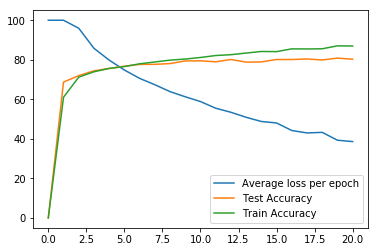

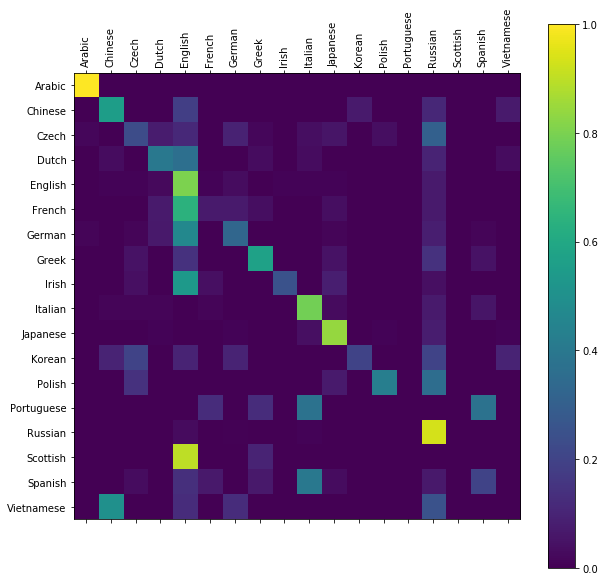

In [13]:
%%time
rnn_model = NameClassifierRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
if(train_on_gpu): rnn_model.cuda()
train(rnn_model, epochs=20, lr=0.001)

In [18]:
class NameClassifierLSTM(nn.Module):
    def __init__(
        self, 
        batch_size, 
        n_steps, 
        n_inputs, 
        n_outputs, 
        n_neurons, 
        n_layers=1,
        drop_prob=1.0
    ):
        super(NameClassifierLSTM, self).__init__()
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.lstm = nn.LSTM(n_inputs, n_neurons, n_layers, dropout=drop_prob)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        self.dropout = nn.Dropout(drop_prob)
        
    def init_hidden(self):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_neurons,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (
                weight.new(self.n_layers, self.batch_size, self.n_neurons).zero_().cuda(),
                weight.new(self.n_layers, self.batch_size, self.n_neurons).zero_().cuda()
            )
        else:
            hidden = (
                weight.new(self.n_layers, self.batch_size, self.n_neurons).zero_(),
                weight.new(self.n_layers, self.batch_size, self.n_neurons).zero_()
            )
        
        return hidden

    def forward(self, X):
        # transforms X to dimensions: seq-len x batch-size x num-chars
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
                
        lstm_out, self.hidden = self.lstm(X, self.hidden)      
        _, out = self.hidden
        out = self.dropout(out[-1])
        out = self.FC(out)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

Epoch:   1 | Loss: 100.00 | Train Accuracy: 58.08 | Test Accuracy: 65.40
Epoch:   2 | Loss: 100.00 | Train Accuracy: 68.48 | Test Accuracy: 73.30
Epoch:   3 | Loss: 93.72 | Train Accuracy: 72.36 | Test Accuracy: 75.46
Epoch:   4 | Loss: 85.91 | Train Accuracy: 74.53 | Test Accuracy: 77.33
Epoch:   5 | Loss: 80.00 | Train Accuracy: 75.91 | Test Accuracy: 78.53
Epoch:   6 | Loss: 74.85 | Train Accuracy: 77.34 | Test Accuracy: 78.54
Epoch:   7 | Loss: 70.79 | Train Accuracy: 78.44 | Test Accuracy: 80.30
Epoch:   8 | Loss: 67.22 | Train Accuracy: 79.55 | Test Accuracy: 81.09
Epoch:   9 | Loss: 64.20 | Train Accuracy: 80.27 | Test Accuracy: 81.99
Epoch:  10 | Loss: 62.19 | Train Accuracy: 80.85 | Test Accuracy: 81.47
Epoch:  11 | Loss: 59.14 | Train Accuracy: 81.51 | Test Accuracy: 81.82
Epoch:  12 | Loss: 57.22 | Train Accuracy: 82.08 | Test Accuracy: 82.20
Epoch:  13 | Loss: 55.29 | Train Accuracy: 82.73 | Test Accuracy: 82.02
Epoch:  14 | Loss: 53.39 | Train Accuracy: 83.20 | Test Accura

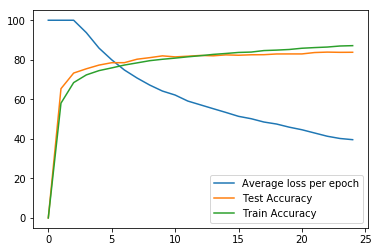

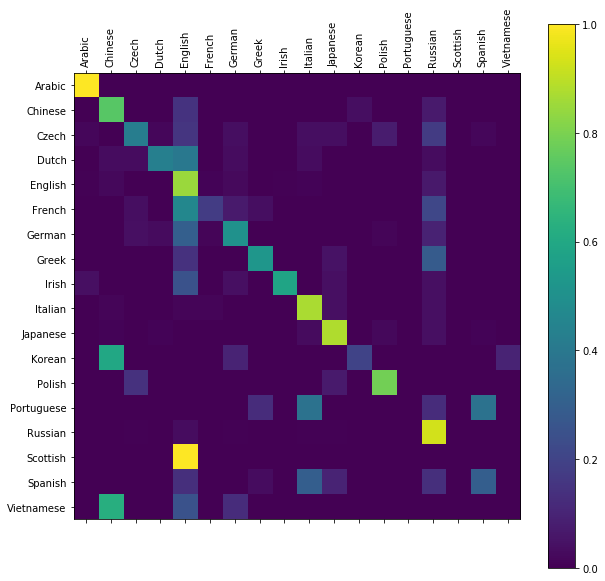

In [28]:
%%time
model = NameClassifierLSTM(
    BATCH_SIZE, 
    N_STEPS, 
    N_INPUTS, 
    N_OUTPUTS, 
    N_NEURONS, 
    n_layers=2, 
    drop_prob=0.65
)
if(train_on_gpu): model.cuda()
train(model, epochs=24, lr=0.001)

Epoch:   1 | Loss: 34.15 | Train Accuracy: 88.92 | Test Accuracy: 83.71
Epoch:   2 | Loss: 32.66 | Train Accuracy: 89.16 | Test Accuracy: 83.46
Epoch:   3 | Loss: 32.83 | Train Accuracy: 89.28 | Test Accuracy: 82.78
Epoch:   4 | Loss: 31.84 | Train Accuracy: 89.53 | Test Accuracy: 83.37
Epoch:   5 | Loss: 30.64 | Train Accuracy: 89.92 | Test Accuracy: 83.21
Epoch:   6 | Loss: 29.58 | Train Accuracy: 90.34 | Test Accuracy: 82.80
Epoch:   7 | Loss: 29.40 | Train Accuracy: 90.23 | Test Accuracy: 82.67
Epoch:   8 | Loss: 29.57 | Train Accuracy: 90.10 | Test Accuracy: 82.93


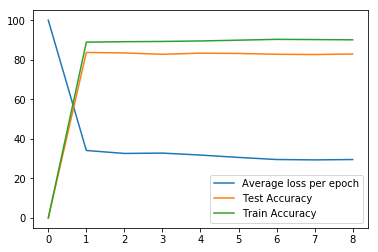

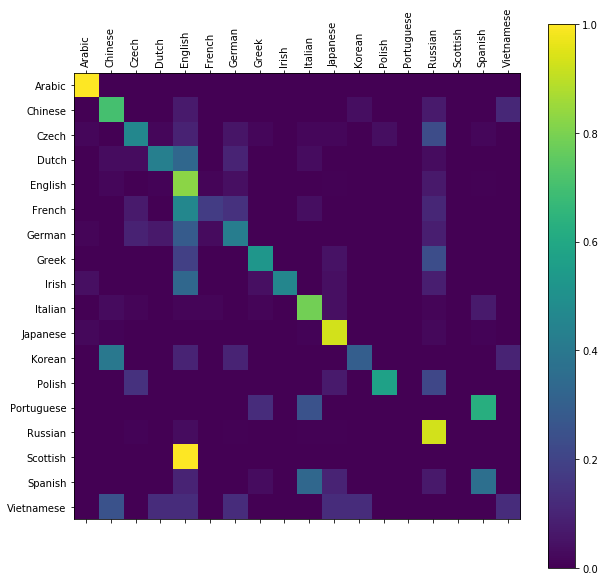

In [25]:
train(model, epochs=8, lr=0.001)

In [ ]:
class ConvSentEncoder(nn.Module):
    """
    Convolutional word-level sentence encoder
    w/ max-over-time pooling, [3, 4, 5] kernel sizes, ReLU activation
    """
    def __init__(self, vocab_size, emb_dim, n_hidden, dropout):
        super().__init__()
        self._embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self._convs = nn.ModuleList([nn.Conv1d(emb_dim, n_hidden, i)
                                     for i in range(3, 6)])
        self._dropout = dropout
        self._grad_handle = None

    def forward(self, input_):
        emb_input = self._embedding(input_)
        conv_in = F.dropout(emb_input.transpose(1, 2),
                            self._dropout, training=self.training)
        output = torch.cat([F.relu(conv(conv_in)).max(dim=2)[0]
                            for conv in self._convs], dim=1)
        return output

    def set_embedding(self, embedding):
        """embedding is the weight matrix"""
        assert self._embedding.weight.size() == embedding.size()
        self._embedding.weight.data.copy_(embedding)


In [ ]:
%%time

all_losses = []
all_train_acc = []
all_test_acc = []


for epoch in range(24):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(-1, seq_length, num_chars) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    epoch_loss = 100 * train_running_loss / i
    all_losses.append(epoch_loss)
    epoch_train_acc = train_acc / i
    all_train_acc.append(epoch_train_acc)
    
    test_acc = 0.0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(-1, seq_length, num_chars) 
        outputs = model(inputs)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    epoch_test_acc = test_acc / i
    all_test_acc.append(epoch_test_acc)
    print(
        'Epoch:  %2d | Loss: %3.2f | Train Accuracy: %.2f | Test Accuracy: %.2f' %
        (epoch + 1, epoch_loss, epoch_train_acc, epoch_test_acc)
    )


In [ ]:

plt.figure()
plt.plot([l for l in all_losses[1:]])
plt.plot(all_test_acc)
plt.plot(all_train_acc)
plt.legend(['Average loss per epoch','Test Accuracy','Train Accuracy']);

In [ ]:
confusion = torch.zeros(num_classes, num_classes)

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
    inputs = inputs.view(-1, seq_length, num_chars) 
    logit = model(inputs)
    result = torch.max(logit, 1)[1].view(labels.size()).data
    for index in range(labels.size()[0]):
        i = int(labels[index])
        j = int(result[index])
        confusion[i][j] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + distinct_labels, rotation=90)
ax.set_yticklabels([''] + distinct_labels)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))



In [ ]:
train(model, epochs=6)

## Old Stuff

In [ ]:
data = []
for key, values in category_lines.items():
    for name in values: data.append((name, key))
shuffle(data)
names = [name for name, key in data]
labels = [key for name, key in data]
print("# names:", len(names))
print("# labels:", len(labels))
n = 10
for i in range(n):
    print("%19s -->> %s" % (names[i], labels[i]))

In [ ]:
confusion = torch.zeros(num_classes, num_classes)

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
    inputs = inputs.view(-1, seq_length, num_chars) 
    outputs = model(inputs)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.long().data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))




In [ ]:

def embed2name(values, indices):
    return decode_name([int(indices[i]) for i in range(seq_length) if values[i] == 1])
    
def embed2names(names):
    
    batch_size = names.shape[0]
    values, indices = torch.topk(names, 1)
    if values.shape[-1] != 1:
        values = values.squeeze()
        indices = indices.squeeze()
    return [
        embed2name(values[i], indices[i]) for i in range(batch_size)
    ]

In [ ]:
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    break
print("inputs:", inputs.shape)
print("labels:", labels.size())

In [ ]:
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.long().data).sum()



In [ ]:
def predict(name):
    inputs = embed_names([name])
    print(inputs.shape, name, "||", embed2names(inputs)[0])
    model.eval()

    inputs, labels = data
    if(train_on_gpu): inputs = inputs.cuda()
    inputs = inputs.view(-1, seq_length, num_chars) 
    logit = model(inputs)
    xx = torch.max(logit, 1)[1].view(1).data
    print(xx.shape)
    print(xx)

        
    values, indices = torch.topk(output, 1)
    category = codes2labels(indices.cpu().data.numpy())[0]
    return category
    
for name in ['Dovesky', 'Jackson', 'Satoshi']:
    print(name, '-->>', predict(name))



In [ ]:

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, seq_length, num_chars) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))



In [ ]:
test_acc = 0.0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, seq_length, num_chars) 

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

## Building the network

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu): print('Using GPU.')
else: print('No GPU available, using CPU.')

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    The RNN model that will be used to classify names by nationality.
    """

    def __init__(
        self, 
        vocab_size, 
        output_size, 
        hidden_dim, 
        n_layers, 
        drop_prob=1.0
    ):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTMClassifier, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.lstm = nn.LSTM(
            vocab_size, 
            hidden_dim, 
            n_layers, 
            dropout=drop_prob, 
            batch_first=True
        )
        
        # dropout layer
        #self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.softmax = nn.LogSoftmax()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        lstm_out, hidden = self.lstm(x, hidden)
    
        # stack up lstm outputs
        out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        #out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, seq_length, -1)
        out = out[:, -1]
        # softmax function
        #softmax_out = self.softmax(out)
        
        # reshape to be batch_size first
        #softmax_out = softmax_out.view(batch_size, -1)
        #softmax_out = softmax_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        if (train_on_gpu):
            hidden = (
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            )
        else:
            hidden = (
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
            )
        return hidden
        #return tuple([each.long() for each in h])



## Instantiate the network

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = num_chars
output_size = num_classes
hidden_dim = 256
n_layers = 1

net = LSTMClassifier(vocab_size, output_size, hidden_dim, n_layers)

print(net)

## Training

In [ ]:
lr=0.001
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

data = TensorDataset(embedded_names, encoded_labels)
batch_size = 16
loader = DataLoader(data, shuffle=True, batch_size=batch_size)

In [ ]:
# training params

epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 1000
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu): net.cuda()

# train for some number of epochs
for e in range(epochs):
    net.train()
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in loader:
        this_batch_size = int(inputs.shape[0])
        if this_batch_size != batch_size: continue
        counter += 1

        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        
        #print("%d. inputs:" % e, inputs.size(), inputs.shape)
        #print("labels:", labels.size(), labels.shape)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data[:this_batch_size] for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        #loss = criterion(output.squeeze(), labels.float())
        #print("output:", output.size(), output.shape)
        #print("h:", len(h), h[0].shape)
        loss = criterion(output, labels.long())

        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
    # Get validation loss after each epoch
    val_h = net.init_hidden(batch_size)
    val_losses = []
    net.eval()
    for inputs, labels in loader:
        this_batch_size = int(inputs.shape[0])
        if this_batch_size != batch_size: continue

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data[:this_batch_size] for each in val_h])

        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()

        output, val_h = net(inputs, val_h)
        val_loss = criterion(output, labels.long())

        val_losses.append(val_loss.item())

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))

## Predict

In [ ]:
def predict(name):
    inputs = embed_names([name])
    print(inputs.shape, name, "||", embed2names(inputs)[0])
    net.eval()
    h = net.init_hidden(1)
    h = tuple([each.data for each in h])
    if(train_on_gpu): inputs = inputs.cuda()
    output, h = net(inputs, h)
    #output, h = net(inputs, h)
    print(output.shape, output)
    values, indices = torch.topk(output, 1)
    category = codes2labels(indices.cpu().data.numpy())[0]
    return category
    
for name in ['Dovesky', 'Jackson', 'Satoshi']:
    print(name, '-->>', predict(name))



In [ ]:

def embed2name(values, indices):
    return decode_name([int(indices[i]) for i in range(seq_length) if values[i] == 1])
    
def embed2names(names):
    batch_size = names.shape[0]
    values, indices = torch.topk(names, 1)
    #values = values.squeeze()
    #indices = indices.squeeze()
    return [
        embed2name(values[i].squeeze(), indices[i].squeeze()) for i in range(batch_size)
    ]



In [ ]:
inputs = embed_names([name])
print("inputs.shape:", inputs.shape)
batch_size = inputs.shape[0]
print("batch_size:", batch_size)
values, indices = torch.topk(inputs, 1)
print("values:", values.shape)
print("indices:", indices.shape)
#values[0].squeeze()

#values = values.squeeze()
#indices = indices.squeeze()
embed2names(inputs)



In [ ]:
print(", ".join([int2label[int(i)] for i in encoded_labels[:10]]))

def decode_label(some_labels): return [int2label[int(i)] for i in codes]

In [ ]:
%%time

seq_length = np.max([len(name) for name in names])
print("seq-length: %d" % seq_length, "num_chars:", num_chars)

def embed_names(some_names):
    some_names_encoded = encode_names(some_names)
    some_names_embedded = np.zeros((len(some_names), seq_length, num_chars), dtype=np.long)
    index = 0
    for name in some_names_encoded:
        position = seq_length - len(name)
        for char in name: 
            #print(index, position, char2int[char])
            one_hot_data_x[index, position, char2int[char]] = 1
            position += 1
        index += 1
    return some_names_embedded


one_hot_data_x = np.zeros((len(names), seq_length, num_chars), dtype=np.long)
index = 0
for name in names:
    position = seq_length - len(name)
    for char in name: 
        #print(index, position, char2int[char])
        one_hot_data_x[index, position, char2int[char]] = 1
        position += 1
    index += 1
print("one_hot_data_x:", one_hot_data_x.shape)
one_hot_data_x = torch.from_numpy(one_hot_data_x)
print("one_hot_data_x:", one_hot_data_x.shape)

In [ ]:
def debed_name(name, values, indices):
    return decode_name([indices[i] for i in range(seq_length) if values[i] == 1])
    
def debed_names(names):
    batch_size = names.shape[0]
    values, indices = torch.topk(names, 1)
    values = values.squeeze()
    indices = indices.squeeze()
    return [
        indices(names[i], values[i], indices[i]) for i in range(batch_size)
    ]

n = 10
decoded_names = decode_names(one_hot_data_x[:n])
for i in range(n):
    print("%19s -->> %s" % (decoded_names[i], labels[i]))

In [ ]:
values, indices = torch.topk(one_hot_data_x[:10], 1)
print(values.squeeze().shape)

In [ ]:
def one_hot_embedding(names, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes, dtype=torch.int) 
    return y[names] 

def one_hot_decode_name(one_hot): 
    return [int2char[int(i)] for i in torch.argmax(one_hot, dim=1)]

one_hot_data_x = one_hot_embedding(names_ints, num_classes)
print(one_hot_data_x.shape)
print(data_y[:10,:])
decode_label(data_y[:10,:])

### Padding sequences

In [ ]:
def pad_features(names, seq_length):
    ''' Return features of names_ints, where each name is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(names), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, name in enumerate(names):
        features[i, -len(name):] = np.array(name)[:seq_length]
    
    return features

In [ ]:
seq_length = np.max([len(name) for name in names])
print("seq-length: %d" % seq_length)

def names2tensors(names):
    names_ints = encode_names(names)
    features = pad_features(names_ints, seq_length=seq_length)
    return torch.from_numpy(features)

data_x = names2tensors(names)

# print first 10 values of the first 30 batches 
for row in data_x[:10,:]: print(row.numpy(), '-->>', decode_name(row))



In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

data = TensorDataset(data_x, data_y)
batch_size = 16
loader = DataLoader(data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

In [ ]:
for index in range(batch_size):
    print("%19s -->> %s" % (
        decode_name(sample_x[index].numpy()), 
        decode_label(sample_y)[index]
    ))

## Building the network

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu): print('Using GPU.')
else: print('No GPU available, using CPU.')

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    The RNN model that will be used to classify names by nationality.
    """

    def __init__(
        self, 
        vocab_size, 
        output_size, 
        embedding_dim, 
        hidden_dim, 
        n_layers, 
        drop_prob=0.5
    ):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTMClassifier, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            dropout=drop_prob, 
            batch_first=True
        )
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, seq_length, -1)
        out = out[:, -1]
        # softmax function
        #softmax_out = self.softmax(out)
        
        # reshape to be batch_size first
        #softmax_out = softmax_out.view(batch_size, -1)
        #softmax_out = softmax_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        if (train_on_gpu):
            hidden = (
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            )
        else:
            hidden = (
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
            )
        return hidden

## Instantiate the network

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(char2int)+1 # +1 for the 0 padding + our word tokens
output_size = num_classes
embedding_dim = 10
hidden_dim = 64
n_layers = 1

net = LSTMClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

## Training

In [ ]:
lr=0.001
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
# training params

epochs = 100 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu): net.cuda()

# train for some number of epochs
for e in range(epochs):
    net.train()
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in loader:
        this_batch_size = int(inputs.shape[0])
        if this_batch_size != batch_size: continue
        counter += 1

        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
        
        #print("%d. inputs:" % e, inputs.size(), inputs.shape)
        #print("labels:", labels.size(), labels.shape)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data[:this_batch_size] for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        #loss = criterion(output.squeeze(), labels.float())
        #print("output:", output.size(), output.shape)
        #print("h:", len(h), h[0].shape)
        loss = criterion(output, labels)

        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
    # Get validation loss after each epoch
    val_h = net.init_hidden(batch_size)
    val_losses = []
    net.eval()
    for inputs, labels in loader:
        this_batch_size = int(inputs.shape[0])
        if this_batch_size != batch_size: continue

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data[:this_batch_size] for each in val_h])

        if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()

        output, val_h = net(inputs, val_h)
        val_loss = criterion(output, labels)

        val_losses.append(val_loss.item())

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [ ]:
def predict(name):
    inputs = names2tensors([name])
    net.eval()
    h = net.init_hidden(1)
    h = tuple([each.data for each in h])
    if(train_on_gpu): inputs = inputs.cuda()
    output, h = net(inputs, h)
    values, indices = torch.topk(output, 1)
    value = indices.cpu().data.numpy()[0]
    category = decode_label(value)
    return category
    
for name in ['Dovesky', 'Jackson', 'Satoshi']:
    print(name, '-->>', predict(name))

    

In [ ]:
values, indices = torch.topk(data_y[:10,:], 1)
indices

In [ ]:
import numpy as np

######################################################################
# Running on User Input
# ---------------------
#

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



## Simple RNN

- [Pytorch RNN text classification
](https://www.kaggle.com/geeklund/pytorch-rnn-text-classification)
- [Sentiment Analysis with Variable length sequences in Pytorch](https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130)
- [Torch Docs:Recurrent layers](https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN)


In [ ]:
import torch
from torch import nn

In [ ]:
nn.RNN(
    input_size=, 
    hidden_size=, 
    num_layers=1, 
    nonlinearity='relu', 
    batch_first=True,
    dropout=0.0,
    bidirectional=False
)

In [ ]:
vocab_size = len(words)
embedding_dim = 4
n_hidden = 5
n_out = 2

class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        print('batch size', bs)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        print('Inititial hidden state shape', self.h.shape)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        print('GRU output(all timesteps)', gru_out.shape)
        print(gru_out)
        print('GRU last timestep output')
        print(gru_out[-1])
        print('Last hidden state', self.h)
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1,batch_size,self.n_hidden)))
      
      
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out)
print(m)

'''
SimpleGRU(
  (emb): Embedding(773042, 4)
  (gru): GRU(4, 5)
  (out): Linear(in_features=5, out_features=2, bias=True)
)
'''

# function to sort batch according to tweet length
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq_length) to (seq_length x batch)
  

dl = DataLoader(ds, batch_size=3)
it = iter(dl)
xs,ys,lens =  next(it)
xs,ys,lens = sort_batch(xs,ys,lens)
outp = m(xs,lens.cpu().numpy())

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim=hidden_dim
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [ ]:
def findFiles(path): return glob.glob(path)

In [ ]:
print(findFiles('data/names/*.txt'))

In [ ]:
import unicodedata
import string

In [ ]:
all_letters

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [ ]:
print(unicodeToAscii('Ślusàrski'))

In [ ]:
######################################################################
# Turning Names into Tensors
# --------------------------
#
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
#
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
#
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
#
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.
#
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

In [ ]:
######################################################################
# Creating the Network
# ====================
#
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
#
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
#
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:
#
#

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [ ]:
######################################################################
# To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).
#

input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)


In [ ]:
######################################################################
# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``lineToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
#

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)


In [ ]:
######################################################################
# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
#

In [ ]:
######################################################################
#
# Training
# ========
# Preparing for Training
# ----------------------
#
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
#

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    #print(top_n[0].item(), top_i[0].item())
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))


In [ ]:
######################################################################
# We will also want a quick way to get a training example (a name and its
# language):
#

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

In [ ]:
######################################################################
# Training the Network
# --------------------
#
# Now all it takes to train this network is show it a bunch of examples,
# have it make guesses, and tell it if it's wrong.
#
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
#

criterion = nn.NLLLoss()

In [ ]:
######################################################################
# Each loop of training will:
#
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
#
#    -  Keep hidden state for next letter
#
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
#

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
######################################################################
# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
#

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [ ]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
######################################################################
# Plotting the Results
# --------------------
#
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline  

plt.figure()
plt.plot(all_losses)


In [ ]:
######################################################################
# Evaluating the Results
# ======================
#
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
#

# Keep track of correct guesses in a confusion matrix
n_categories = len(set(all_categories))
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))



In [ ]:
# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))



In [ ]:
######################################################################
# You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
#


In [ ]:
import numpy as np

######################################################################
# Running on User Input
# ---------------------
#

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


In [ ]:
######################################################################
# The final versions of the scripts `in the Practical PyTorch
# repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
# split the above code into a few files:
#
# -  ``data.py`` (loads files)
# -  ``model.py`` (defines the RNN)
# -  ``train.py`` (runs training)
# -  ``predict.py`` (runs ``predict()`` with command line arguments)
# -  ``server.py`` (serve prediction as a JSON API with bottle.py)
#
# Run ``train.py`` to train and save the network.
#
# Run ``predict.py`` with a name to view predictions:
#
# ::
#
#     $ python predict.py Hazaki
#     (-0.42) Japanese
#     (-1.39) Polish
#     (-3.51) Czech
#
# Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
# output of predictions.
#


######################################################################
# Exercises
# =========
#
# -  Try with a different dataset of line -> category, for example:
#
#    -  Any word -> language
#    -  First name -> gender
#    -  Character name -> writer
#    -  Page title -> blog or subreddit
#
# -  Get better results with a bigger and/or better shaped network
#
#    -  Add more linear layers
#    -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
#    -  Combine multiple of these RNNs as a higher level network
#